# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [10]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import utils_prep
from api import Benchmark
import utils_prep2
import torch

In [11]:
bench_dir = "/home/sven/LCBench/data/11604705/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [12]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [13]:
# Config
print("Config example:", test_data[0]["config"])
print("\n")
print("DATA Keys:", test_data[0].keys())

Config example: {'batch_size': 93, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.06145480624960298, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 402, 'mlp_shape': 'funnel', 'num_layers': True, 'learning_rate': 0.07306153347321286, 'momentum': 0.5844418984083981, 'weight_decay': 0.05967268273584057}


DATA Keys: dict_keys(['config', 'Train/loss', 'Train/train_accuracy', 'Train/val_accuracy', 'Train/train_cross_entropy', 'Train/val_cross_entropy', 'Train/train_balanced_accuracy', 'Train/val_balanced_accuracy', 'Train/test_result', 'Train/test_cross_entropy', 'Train/test_balanced_accuracy', 'Train/gradient_max', 'Train/gradient_mean', 'Train/gradient_median', 'Train/gradient_std', 'Train/gradient_q10', 'Train/gradient_q25', 'Train/gradient_q75', 'Train/gradient_q90',

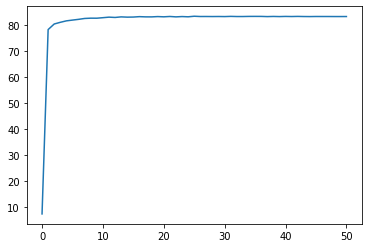

In [14]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

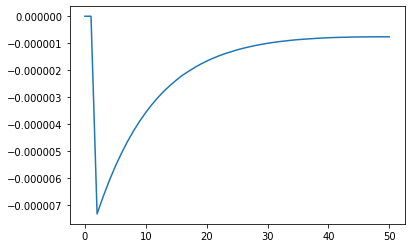

In [15]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

In [16]:
device = utils_prep2.check_cuda()


In [17]:
class LSTM_Net(torch.nn.Module):
    
    def __init__(self, input_size, num_classes, embedding_dim, hidden_size, seq_length, 
                 num_layers, config_size, bidirectional = False, drop_prob=0.5, relative_size = 0.2):
        super(LSTM_Net, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.config_size = config_size
        
        # self.forecaster = torch.nn.Embedding(100, embedding_dim)

        self.dropout = torch.nn.Dropout(drop_prob)
        self.lstm = torch.nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.num_layers, dropout =drop_prob, bidirectional = bidirectional)
        
 
        
        self.linear1 = torch.nn.Linear(self.config_size, int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear2 = torch.nn.Linear(int(self.hidden_dim*relative_size),
                                       int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear3 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size),
                                       self.hidden_dim + int(self.hidden_dim*relative_size))

        
        self.linear4 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size), self.hidden_dim//2)
        
        self.linear5 = torch.nn.Linear(self.hidden_dim//2, num_classes)

    
    def forward(self, x, configs, hidden):
        
        batch_size = x.size(0)

        x=x.unsqueeze(0)
        
        x = x.float()
        
        #forecast = self.forecaster(x)

        lstm_x, hidden = self.lstm(x, hidden)
        lstm_x = lstm_x.contiguous().view(-1, self.hidden_dim)
        x = self.dropout(lstm_x)

                                       
        x_config = torch.nn.functional.relu(self.linear1(configs))
        x_config = torch.nn.functional.relu(self.linear2(x_config))

        x_cat =  torch.cat([x, x_config], dim =1)

        
        x_cat = torch.nn.functional.relu(self.linear3(x_cat))
        x_cat = torch.nn.functional.relu(self.linear4(x_cat))
        x_cat = self.linear5(x_cat)

        
        x_cat = x_cat.view(batch_size, -1)
        x_cat = x_cat[:,-1]
        
        return x_cat, hidden
    
    def init_hidden(self, batch_size = 32):
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    

In [18]:
def create_model(input_size = 10):

    input_size = input_size
    outcome_dim = 1
    embedding_dim = 400
    hidden_dim = 50
    seq_length = 1
    num_layers = 3
    config_size = 7

    model = LSTM_Net(input_size, outcome_dim, embedding_dim, hidden_dim, seq_length, num_layers, config_size,
                     relative_size = 0.75)
    model.to(device)

    lr=0.001
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    return model, optimizer, criterion

In [19]:
def train_validate_model(model, optimizer, criterion):
    
    epochs = 1000
    counter = 0
    print_every = 20

    clip = 5
    valid_loss_min = np.Inf


    model.train()

    for i in range(epochs):


        for batches, configs , labels in train_data_loader:
            counter += 1

            batch_size_calc = len(labels)
            hidden = model.init_hidden(batch_size=batch_size_calc)


            model.zero_grad()

            output, hidden = model(batches, configs, hidden)


            loss = abs(criterion(output.squeeze(), labels.float()))
            loss.backward()


            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()


            if counter%print_every == 0:

                val_losses = []
                model.eval()

                for inp,configs, lab in val_data_loader:

                    batch_size_calc = len(lab)

                    val_h = model.init_hidden(batch_size = batch_size_calc)


                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, configs,val_h)
                    val_loss = abs(criterion(out.squeeze(), lab.float()))
                    val_losses.append(val_loss.item())

                    print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), '/home/sven/LCBench/state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)


    return


In [20]:
def test_model(model, criterion):
    
    model.load_state_dict(torch.load('/home/sven/LCBench/state_dict.pt'))

    test_losses = []
    msqrt = 0



    model.eval()
    for inputs,configs, labels in test_data_loader:

        batch_size_calc = len(labels)
        h = model.init_hidden(batch_size_calc)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs,configs, h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        pred = (output.squeeze())

        msqrt = msqrt + mean_squared_error(labels.detach().numpy(), pred.detach().numpy())

    test_acc = msqrt/len(test_data_loader.dataset)
    print("Msqrt: {:.3f}".format(test_acc))

    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    
    return test_acc, np.mean(test_losses)


In [21]:
from utils import prep_data



train_data_loader = prep_data(train_data, train_targets, batch_size = 32,first_n_epochs = 10 )
test_data_loader = prep_data(test_data, test_targets, batch_size = 32,first_n_epochs = 10 )
val_data_loader = prep_data(val_data, val_targets, batch_size = 32, first_n_epochs=10)


model, optimizer, criterion = create_model(input_size = 10)
train_validate_model(model, optimizer, criterion)
test_acc, msqrt = test_model(model, criterion)
    
    


Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6162.513672
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6302.613281
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6327.518392
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6313.452393
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6284.448828
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6250.117188
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6281.410435
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6278.983032
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6303.254286
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6286.024902
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6271.825284
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6279.081095
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6289.836614
Epoch: 1/1000... Step: 20... Loss: 6244.892578... Val Loss: 6281

Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 33.528160
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 29.113850
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 29.956129
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 27.426468
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 31.643232
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 33.477204
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 30.626811
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 28.749704
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 29.272823
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 28.888476
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 29.824774
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 30.587254
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 30.603291
Epoch: 5/1000... Step: 160... Loss: 67.792755... Val Loss: 31.376769
Epoch: 5/1000... Step: 160... Loss

Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 11.661386
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 11.076299
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 14.180156
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 12.650356
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 14.540130
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 14.242317
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 12.826062
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 11.810827
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 11.880233
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 11.589482
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 12.048703
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 13.040587
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 13.329832
Epoch: 10/1000... Step: 320... Loss: 19.379145... Val Loss: 14.086159
Epoch: 10/1000... St

Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 8.404158
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 6.850079
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 8.064686
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.573446
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 8.838985
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 8.506781
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.811905
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.213353
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.199683
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 6.940395
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.186338
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.687841
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 7.886970
Epoch: 15/1000... Step: 480... Loss: 6.483727... Val Loss: 8.552706
Epoch: 15/1000... Step: 480... Loss: 6.483727...

Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 9.915207
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 8.673950
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 10.212856
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 9.798135
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 10.936532
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 10.453538
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 9.644935
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 8.990844
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 8.716546
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 8.488484
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 8.501470
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 9.191929
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 9.239931
Epoch: 20/1000... Step: 640... Loss: 7.218874... Val Loss: 10.134992
Epoch: 20/1000... Step: 640... Loss: 7.21887

Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.310158
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 5.283143
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.965036
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.649049
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 7.549141
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 7.290304
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.803735
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.403123
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.313088
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.107374
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.071336
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.507064
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 6.687960
Epoch: 25/1000... Step: 800... Loss: 2.906013... Val Loss: 7.439148
Epoch: 25/1000... Step: 800... Loss: 2.906013...

Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.073465
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 4.015185
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 6.116568
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 6.027351
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 6.909413
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 6.519957
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 6.120255
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.848402
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.772009
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.471184
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.303831
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.658745
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 5.867170
Epoch: 30/1000... Step: 960... Loss: 0.940974... Val Loss: 6.498945
Epoch: 30/1000... Step: 960... Loss: 0.940974...

Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 3.991374
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 3.393980
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 4.821753
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 4.938482
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 6.154201
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.865441
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.460684
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.308198
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.181111
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 4.893667
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 4.724034
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.029014
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.152577
Epoch: 35/1000... Step: 1120... Loss: 0.352139... Val Loss: 5.796588
Epoch: 35/1000... Step: 1120... Lo

Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 4.472347
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 4.599939
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.280227
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.264573
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 7.349302
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 7.072831
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.590896
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.236133
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.050348
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 5.761152
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 5.606361
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.021227
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 5.974060
Epoch: 40/1000... Step: 1280... Loss: 0.262110... Val Loss: 6.883278
Epoch: 40/1000... Step: 1280... Lo

Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 2.687100
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 2.901050
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.307774
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.509808
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 5.496799
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 5.467622
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 5.038778
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.785433
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.591367
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.417446
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.321315
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.629297
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 4.556976
Epoch: 45/1000... Step: 1440... Loss: 1.945076... Val Loss: 5.420339
Epoch: 45/1000... Step: 1440... Lo

Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 10.541932
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 8.420434
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 9.775359
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 10.368332
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.092901
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.141142
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 10.947011
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.560924
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.510611
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.158216
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 10.947667
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.265419
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 11.495571
Epoch: 50/1000... Step: 1600... Loss: 4.729966... Val Loss: 12.014093
Epoch: 50/1000... Step

Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 2.755353
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 2.609885
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.247448
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.244388
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 5.375616
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 5.267654
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.818034
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.624105
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.474101
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.308700
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.111622
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.515312
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 4.428345
Epoch: 55/1000... Step: 1760... Loss: 1.485510... Val Loss: 5.250848
Epoch: 55/1000... Step: 1760... Lo

Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 3.680945
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 2.845380
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 4.444951
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 4.828252
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.797524
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.778977
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.392703
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.521681
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.327286
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.040004
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 4.882518
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.277218
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.238382
Epoch: 60/1000... Step: 1920... Loss: 1.490542... Val Loss: 5.899674
Epoch: 60/1000... Step: 1920... Lo

Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 4.295086
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 3.189658
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 4.222026
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 4.597298
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.601056
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.480238
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.129168
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.449717
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.264599
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 4.979589
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 4.851099
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.188631
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.169869
Epoch: 65/1000... Step: 2080... Loss: 0.895768... Val Loss: 5.858427
Epoch: 65/1000... Step: 2080... Lo

Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 4.247427
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 4.632332
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.137769
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.214673
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 7.306650
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.883655
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.437524
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.228067
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.016522
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 5.748550
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 5.508501
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 5.879852
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 5.709484
Epoch: 70/1000... Step: 2240... Loss: 0.995119... Val Loss: 6.660172
Epoch: 70/1000... Step: 2240... Lo

Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 2.943177
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 2.478770
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.061842
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.121971
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 5.226468
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.950796
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.484340
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.398308
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.198656
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 3.988309
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 3.804021
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.090939
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 3.987286
Epoch: 75/1000... Step: 2400... Loss: 0.861197... Val Loss: 4.793950
Epoch: 75/1000... Step: 2400... Lo

Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 3.322020
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 3.597427
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 5.190511
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 5.232145
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 6.247984
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 5.760955
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 5.274708
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 5.089375
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 4.897447
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 4.668079
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 4.445861
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 4.778644
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 4.626136
Epoch: 80/1000... Step: 2560... Loss: 1.901670... Val Loss: 5.515271
Epoch: 80/1000... Step: 2560... Lo

Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 3.575713
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 2.822793
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 4.010313
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 4.566874
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.619001
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.465701
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.136900
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.415662
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.276858
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 4.914744
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 4.751397
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.186524
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.179385
Epoch: 85/1000... Step: 2720... Loss: 0.573534... Val Loss: 5.831512
Epoch: 85/1000... Step: 2720... Lo

Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 7.253218
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 6.877980
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 6.668782
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 6.994959
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 7.020032
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 7.626821
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 7.894798
Epoch: 90/1000... Step: 2860... Loss: 3.213794... Val Loss: 7.944543
Epoch: 90/1000... Step: 2880... Loss: 2.964799... Val Loss: 4.878088
Epoch: 90/1000... Step: 2880... Loss: 2.964799... Val Loss: 5.749239
Epoch: 90/1000... Step: 2880... Loss: 2.964799... Val Loss: 6.695377
Epoch: 90/1000... Step: 2880... Loss: 2.964799... Val Loss: 6.837942
Epoch: 90/1000... Step: 2880... Loss: 2.964799... Val Loss: 7.498864
Epoch: 90/1000... Step: 2880... Loss: 2.964799... Val Loss: 7.082758
Epoch: 90/1000... Step: 2880... Lo

Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 3.486663
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 2.740977
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.147495
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.344152
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 5.231595
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.979251
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.622091
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.855525
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.695886
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.429866
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.238113
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.576432
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 4.636385
Epoch: 95/1000... Step: 3020... Loss: 2.180410... Val Loss: 5.380511
Epoch: 95/1000... Step: 3020... Lo

Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 2.596226
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 2.535183
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 4.093350
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 4.044727
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 5.041874
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 4.658796
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 4.200136
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 4.096750
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 3.926525
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 3.737732
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 3.519943
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 3.802287
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 3.696879
Epoch: 100/1000... Step: 3180... Loss: 1.431828... Val Loss: 4.548527
Epoch: 100/1000... S

Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 2.809666
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 3.159827
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.482708
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.533823
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 5.483773
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 5.092958
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.643644
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.549354
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.384695
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.216272
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.031418
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.315725
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 4.149619
Epoch: 105/1000... Step: 3340... Loss: 1.988541... Val Loss: 5.014810
Epoch: 105/1000... S

Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 2.441240
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 2.309455
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.506125
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.651606
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 4.701477
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 4.487763
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 4.072717
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 4.128353
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.936934
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.728592
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.588500
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.955087
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 3.916984
Epoch: 110/1000... Step: 3500... Loss: 1.491162... Val Loss: 4.672607
Epoch: 110/1000... S

Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 2.801905
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 2.533320
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.675538
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.729385
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 4.620984
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 4.287477
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.887894
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.917679
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.749045
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.546423
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.372392
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.690589
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 3.592026
Epoch: 115/1000... Step: 3660... Loss: 1.589197... Val Loss: 4.413643
Epoch: 115/1000... S

Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 2.398335
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 2.378885
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.647537
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.513779
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 4.750115
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 4.453801
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.973806
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.831265
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.681305
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.500050
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.338413
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.682171
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 3.622267
Epoch: 120/1000... Step: 3820... Loss: 1.647099... Val Loss: 4.464351
Epoch: 120/1000... S

Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 2.708723
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 2.504046
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.870564
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.932066
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 4.778035
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 4.397751
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.985459
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 4.077275
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.893869
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.712822
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.514510
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.760347
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 3.625911
Epoch: 125/1000... Step: 3980... Loss: 2.158736... Val Loss: 4.416230
Epoch: 125/1000... S

Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 2.698073
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 2.816430
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.331095
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.208828
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 5.437258
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.980777
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.456919
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.205723
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.029633
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 3.862207
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 3.647789
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 3.984929
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 3.841363
Epoch: 130/1000... Step: 4140... Loss: 1.310876... Val Loss: 4.753609
Epoch: 130/1000... S

Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 2.974206
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 2.369808
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.458385
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.689720
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 4.591454
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 4.305855
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.947172
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 4.217713
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 4.055164
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.804653
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.611749
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.942533
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 3.917474
Epoch: 135/1000... Step: 4300... Loss: 1.851150... Val Loss: 4.647697
Epoch: 135/1000... S

Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 5.002341
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 4.408053
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 5.569934
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 5.775257
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.773890
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.656301
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.347667
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.630452
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.479862
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.198118
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.093009
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.507099
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 6.573509
Epoch: 140/1000... Step: 4460... Loss: 2.266226... Val Loss: 7.242063
Epoch: 140/1000... S

Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 2.352510
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 2.341434
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.745208
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.881604
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 4.891378
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 4.513066
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 4.069274
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 4.089079
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.904480
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.710364
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.505411
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.808459
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 3.659294
Epoch: 145/1000... Step: 4620... Loss: 1.924275... Val Loss: 4.463153
Epoch: 145/1000... S

Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 2.884849
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 2.756016
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 3.680401
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 3.717132
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 5.083256
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.882945
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.424664
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.534355
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.317185
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.107962
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 3.960022
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.338100
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 4.358343
Epoch: 150/1000... Step: 4780... Loss: 1.298859... Val Loss: 5.059096
Epoch: 150/1000... S

Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 2.177701
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 2.188524
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.413800
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.346990
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 4.672977
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 4.489913
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 4.013916
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.942359
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.757361
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.557930
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.427825
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.764695
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 3.692220
Epoch: 155/1000... Step: 4940... Loss: 1.600892... Val Loss: 4.482026
Epoch: 155/1000... S

Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 2.707736
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 3.157974
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.537454
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.511372
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 5.715960
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 5.436831
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.915227
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.656640
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.489618
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.435544
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.321345
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.599249
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 4.378525
Epoch: 160/1000... Step: 5100... Loss: 1.384462... Val Loss: 5.251505
Epoch: 160/1000... S

Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 2.924125
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 2.892903
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 3.588305
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 3.949349
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.827413
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.477009
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.110028
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.183178
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.029695
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 3.809234
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 3.600153
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.023147
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 3.886377
Epoch: 165/1000... Step: 5260... Loss: 1.632265... Val Loss: 4.711617
Epoch: 165/1000... S

Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 2.983675
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 2.423044
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 3.587913
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 3.886576
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.832948
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.583167
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.198071
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.470417
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.333347
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.052110
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 3.863544
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.289061
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 4.311793
Epoch: 170/1000... Step: 5420... Loss: 1.678992... Val Loss: 5.041520
Epoch: 170/1000... S

Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 2.106146
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 2.155957
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.217510
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.181664
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 4.460169
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 4.221102
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.765075
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.755887
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.580691
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.386284
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.253710
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.615765
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 3.542693
Epoch: 175/1000... Step: 5580... Loss: 1.306220... Val Loss: 4.299571
Epoch: 175/1000... S

Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 2.039586
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 2.380644
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.531769
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.525001
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 4.643215
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 4.422656
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.942317
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.865230
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.682696
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.489701
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.290200
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.617995
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 3.490668
Epoch: 180/1000... Step: 5740... Loss: 1.287818... Val Loss: 4.276602
Epoch: 180/1000... S

Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 2.436356
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.483205
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.456444
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 4.702301
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 4.472597
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.999365
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.920994
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.758240
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.574510
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.422109
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.719201
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 3.577768
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 4.407532
Epoch: 185/1000... Step: 5900... Loss: 1.475701... Val Loss: 4.592945
Epoch: 185/1000... S

Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 2.656108
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 2.425115
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.376128
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.524980
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 4.522390
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 4.242035
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.844346
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.811145
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.727153
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.556290
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.436987
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.845898
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 3.819653
Epoch: 190/1000... Step: 6060... Loss: 1.426207... Val Loss: 4.637750
Epoch: 190/1000... S

Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 4.845990
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.176469
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.959598
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 6.102381
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 7.237121
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 6.746427
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 6.258275
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 6.050010
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.885229
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.702169
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.446588
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.730038
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 5.542311
Epoch: 195/1000... Step: 6220... Loss: 1.934371... Val Loss: 6.421783
Epoch: 195/1000... S

Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 2.994631
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 2.605150
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 3.759524
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 3.791504
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 4.587615
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 4.314542
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 3.991555
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 4.199154
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 4.077429
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 3.900589
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 3.775541
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 4.071529
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 3.978104
Epoch: 200/1000... Step: 6380... Loss: 0.944035... Val Loss: 4.714715
Epoch: 200/1000... S

Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 3.320404
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 3.480594
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.424438
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.361327
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 5.427121
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 5.091647
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.597681
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.470967
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.359084
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.211914
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 3.983561
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.290484
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.114271
Epoch: 205/1000... Step: 6540... Loss: 1.422097... Val Loss: 4.957225
Epoch: 205/1000... S

Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 2.352723
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 2.239595
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.550235
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.551232
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 4.655909
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 4.259877
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.811315
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.769955
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.633210
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.500811
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.305985
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.629378
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 3.471164
Epoch: 210/1000... Step: 6700... Loss: 1.781365... Val Loss: 4.253972
Epoch: 210/1000... S

Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 1.925839
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 2.182039
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.521243
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.661900
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 4.664397
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 4.287202
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.850773
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.869772
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.709529
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.525719
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.315184
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.538990
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 3.402042
Epoch: 215/1000... Step: 6860... Loss: 1.499664... Val Loss: 4.177388
Epoch: 215/1000... S

Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 3.779263
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 4.087632
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.202748
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.267673
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 6.364242
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.854039
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.334420
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.175606
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.007502
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 4.916597
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 4.677329
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 4.932442
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 4.730086
Epoch: 220/1000... Step: 7020... Loss: 1.505199... Val Loss: 5.574052
Epoch: 220/1000... S

Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 5.140427
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 5.206280
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 6.224416
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 6.401809
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.368462
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.344166
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.146951
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.651838
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.525815
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.201199
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.142736
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.409693
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 7.446504
Epoch: 225/1000... Step: 7180... Loss: 3.172765... Val Loss: 8.112060
Epoch: 225/1000... S

Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 3.685793
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 3.191083
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.286975
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.480044
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 5.203799
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 5.032218
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.750320
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 5.233149
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 5.101015
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.858256
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.713006
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.953204
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 4.901873
Epoch: 230/1000... Step: 7340... Loss: 1.839825... Val Loss: 5.537179
Epoch: 230/1000... S

Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 2.190749
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 2.375060
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.710172
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.703026
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 4.716018
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 4.492691
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 4.026269
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 4.005981
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.860653
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.742546
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.520338
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.828244
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 3.659010
Epoch: 235/1000... Step: 7500... Loss: 1.353895... Val Loss: 4.478662
Epoch: 235/1000... S

Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 1.849212
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 2.275159
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.619020
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.542489
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 4.392293
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 4.143673
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.726726
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.652569
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.531419
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.426563
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.246006
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.488469
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 3.347814
Epoch: 240/1000... Step: 7660... Loss: 2.280583... Val Loss: 4.183143
Epoch: 240/1000... S

Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 4.025397
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 3.619643
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 4.857048
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 4.814229
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.875906
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.758431
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.479941
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.803282
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.687680
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.433709
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.359461
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.667519
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 5.698961
Epoch: 245/1000... Step: 7820... Loss: 5.823204... Val Loss: 6.376145
Epoch: 245/1000... S

Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 3.809219
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 3.878108
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 4.791881
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 5.017091
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 6.133176
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 5.674994
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 5.221625
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 5.083315
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 4.923014
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 4.788278
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 4.537114
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 4.849306
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 4.656773
Epoch: 250/1000... Step: 7980... Loss: 1.227642... Val Loss: 5.529897
Epoch: 250/1000... S

Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 2.079649
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 2.120821
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 2.970526
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.088828
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 4.141227
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.808072
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.410365
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.391314
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.287992
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.148829
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 2.998888
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.333100
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 3.230850
Epoch: 255/1000... Step: 8140... Loss: 1.342234... Val Loss: 4.018986
Epoch: 255/1000... S

Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 3.038630
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 3.106923
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.159884
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.170059
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 5.144668
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.690518
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.256981
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.049562
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 3.943014
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 3.851856
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 3.680812
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.075700
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 3.902437
Epoch: 260/1000... Step: 8300... Loss: 2.134729... Val Loss: 4.840719
Epoch: 260/1000... S

Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 2.314217
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 2.011374
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.095399
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.154960
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 4.262054
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.945594
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.582571
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.764945
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.621537
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.400809
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.270710
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.664535
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 3.609770
Epoch: 265/1000... Step: 8460... Loss: 1.647898... Val Loss: 4.332744
Epoch: 265/1000... S

Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 3.044079
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 2.542603
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 3.383504
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 3.740561
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.441179
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.223028
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 3.954663
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.540959
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.413879
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.150634
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 3.988968
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.309970
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.316507
Epoch: 270/1000... Step: 8620... Loss: 1.898175... Val Loss: 4.902370
Epoch: 270/1000... S

Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 2.363437
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 2.261017
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.183887
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.438803
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 4.565422
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 4.303821
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.877722
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 4.016909
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.868359
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.634793
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.427484
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.760141
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 3.645396
Epoch: 275/1000... Step: 8780... Loss: 1.907232... Val Loss: 4.353701
Epoch: 275/1000... S

Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 2.351436
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 2.436670
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 3.418268
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 3.525535
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.819497
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.553350
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.132396
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.309723
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.163386
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 3.914062
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 3.759221
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.187471
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.165125
Epoch: 280/1000... Step: 8940... Loss: 1.396914... Val Loss: 4.801095
Epoch: 280/1000... S

Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 3.011789
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 3.084585
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.622841
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.402151
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 5.316804
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 5.058036
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.758447
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.854073
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.765499
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.624831
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.543469
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.798029
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 4.759228
Epoch: 285/1000... Step: 9100... Loss: 2.038368... Val Loss: 5.508868
Epoch: 285/1000... S

Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 3.505631
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 2.968085
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.024868
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.229496
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 5.192554
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.932931
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.638069
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 5.002205
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.891654
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.648139
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.520896
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.877291
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 4.849342
Epoch: 290/1000... Step: 9260... Loss: 2.206262... Val Loss: 5.473613
Epoch: 290/1000... S

Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 3.830831
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 3.684595
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.044669
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 4.998459
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.876019
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.698246
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.402347
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.645666
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.552357
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.362737
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.283323
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.603410
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 5.585467
Epoch: 295/1000... Step: 9420... Loss: 2.335625... Val Loss: 6.269750
Epoch: 295/1000... S

Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 1.811524
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 1.821707
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 2.963348
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.118275
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 4.197031
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 4.025887
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.615321
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.642976
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.512384
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.345583
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.209039
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.533883
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 3.411585
Epoch: 300/1000... Step: 9580... Loss: 1.101688... Val Loss: 4.140230
Epoch: 300/1000... S

Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 3.694724
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 3.505401
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 4.807717
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 4.845658
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.824714
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.669657
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.350450
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.671870
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.570464
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.310091
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.205433
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.611308
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 5.649978
Epoch: 305/1000... Step: 9740... Loss: 2.946037... Val Loss: 6.305889
Epoch: 305/1000... S

Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 2.313183
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 2.787576
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.850173
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.857460
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 4.958548
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 4.646788
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 4.191933
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 4.064616
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.988553
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.892135
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.670888
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.971475
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 3.798689
Epoch: 310/1000... Step: 9900... Loss: 1.258616... Val Loss: 4.580404
Epoch: 310/1000... S

Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 1.976114
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 1.864547
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 2.820421
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.000338
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 4.133936
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.798169
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.413531
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.449539
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.350819
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.187915
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.014736
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.379009
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 3.267090
Epoch: 315/1000... Step: 10060... Loss: 0.935331... Val Loss: 4.034464
Epoch:

Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 2.599561
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 2.286306
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.544815
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.657355
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 4.570110
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 4.286858
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.947373
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 4.180973
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 4.077104
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.932254
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.794366
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.991661
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 3.874893
Epoch: 320/1000... Step: 10220... Loss: 1.154747... Val Loss: 4.563403
Epoch:

Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 1.956291
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 2.187546
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.705213
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.756238
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 4.795066
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 4.454770
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 4.015421
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.793565
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.698125
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.668358
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.552287
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.785005
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 3.620716
Epoch: 325/1000... Step: 10380... Loss: 1.029631... Val Loss: 4.475483
Epoch:

Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 1.759216
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 1.830129
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 2.856146
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 2.912514
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 4.213116
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.841133
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.420616
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.358704
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.275294
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.125973
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 2.970283
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.332189
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.218475
Epoch: 330/1000... Step: 10540... Loss: 1.200701... Val Loss: 3.985046
Epoch:

Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 1.382849
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 1.516873
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 2.805228
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 2.850246
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.981429
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.798149
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.433270
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.329462
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.230153
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.160895
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.133519
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.400450
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 3.293154
Epoch: 335/1000... Step: 10700... Loss: 1.148463... Val Loss: 4.044846
Epoch:

Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 1.488509
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 1.506314
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.035191
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.121206
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 4.443094
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 4.295822
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.886705
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.787703
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.698330
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.572039
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.527571
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.912040
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 3.840188
Epoch: 340/1000... Step: 10860... Loss: 1.425143... Val Loss: 4.573291
Epoch:

Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 2.875600
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 2.527246
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 3.709084
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 3.820431
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.745433
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.525509
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.181319
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.427819
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.309866
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.159237
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.027438
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.250772
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.132294
Epoch: 345/1000... Step: 11020... Loss: 0.990697... Val Loss: 4.839666
Epoch:

Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 1.685925
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 1.926947
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.286653
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.350097
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 4.505621
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 4.240878
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.788740
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.661179
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.545647
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.456451
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.298953
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.560117
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 3.417422
Epoch: 350/1000... Step: 11180... Loss: 1.221648... Val Loss: 4.206320
Epoch:

Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 2.374199
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 2.640479
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.470170
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.615980
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 4.808037
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 4.500508
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 4.077496
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.933935
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.851275
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.722800
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.529826
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.845848
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 3.707668
Epoch: 355/1000... Step: 11340... Loss: 1.143408... Val Loss: 4.519941
Epoch:

Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 2.113950
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 2.239563
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.536741
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.551252
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 4.651378
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 4.511705
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 4.043695
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.857961
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.745208
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.651166
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.487066
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.853483
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 3.694824
Epoch: 360/1000... Step: 11500... Loss: 1.212575... Val Loss: 4.469733
Epoch:

Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 2.229360
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 2.297943
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 3.606826
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 3.705517
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.760018
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.591890
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.202010
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.102348
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.010282
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 3.938907
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 3.815501
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.048909
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 3.869847
Epoch: 365/1000... Step: 11660... Loss: 1.773463... Val Loss: 4.601555
Epoch:

Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 1.493676
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 1.591063
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.098892
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.068436
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 4.310520
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 4.116490
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.705738
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.571293
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.481560
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.409263
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.351471
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.689843
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 3.567016
Epoch: 370/1000... Step: 11820... Loss: 1.375504... Val Loss: 4.333229
Epoch:

Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 2.240535
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 2.401870
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.556270
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.738272
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 4.915345
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 4.629247
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 4.205300
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.975258
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.861838
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.805369
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.668771
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.996320
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 3.825246
Epoch: 375/1000... Step: 11980... Loss: 1.443847... Val Loss: 4.655975
Epoch:

Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 2.105150
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 2.086866
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 2.970366
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.141856
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 4.227871
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.936730
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.537306
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.488561
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.425540
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.296544
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.104523
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.502285
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 3.370824
Epoch: 380/1000... Step: 12140... Loss: 0.984089... Val Loss: 4.067547
Epoch:

Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 1.745663
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 1.860754
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.312367
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.302059
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 4.459983
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 4.169678
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.733837
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.661611
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.547257
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.494302
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.355865
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.644950
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 3.502502
Epoch: 385/1000... Step: 12300... Loss: 1.220861... Val Loss: 4.245331
Epoch:

Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 3.055990
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 3.101807
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 3.879645
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.172307
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 5.384688
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.976079
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.596904
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.463482
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.381956
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.268113
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.047212
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.336732
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.190250
Epoch: 390/1000... Step: 12460... Loss: 1.210733... Val Loss: 4.999538
Epoch:

Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 3.052914
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 3.210172
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 3.950328
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.270902
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 5.365649
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 5.108545
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.720748
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.625488
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.542853
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.442864
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.238579
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.501395
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 4.337063
Epoch: 395/1000... Step: 12620... Loss: 1.337075... Val Loss: 5.073124
Epoch:

Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 1.936142
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 2.121018
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.285566
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.321893
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 4.318783
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 4.208425
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.841636
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 4.023858
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.933930
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.801174
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.639548
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.862404
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 3.761844
Epoch: 400/1000... Step: 12780... Loss: 2.767026... Val Loss: 4.441919
Epoch:

Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 1.740067
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 1.676244
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 2.669632
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 2.935657
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 4.040086
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.780217
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.432916
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.434277
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.353743
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.258379
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.133160
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.459155
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 3.341727
Epoch: 405/1000... Step: 12940... Loss: 0.824179... Val Loss: 4.035250
Epoch:

Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 1.917321
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 1.914960
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.144723
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.148328
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 4.184071
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.938023
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.534041
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.459949
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.372938
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.316058
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.190427
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.475137
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 3.327855
Epoch: 410/1000... Step: 13100... Loss: 1.615684... Val Loss: 4.092780
Epoch:

Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 2.137968
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 1.708822
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 2.489272
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 2.791454
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.871464
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.645738
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.290970
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.480939
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.421253
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.257689
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.127077
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.585342
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 3.570867
Epoch: 415/1000... Step: 13260... Loss: 1.059379... Val Loss: 4.249717
Epoch:

Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 4.364487
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 4.001945
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 4.944841
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 5.080267
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 5.966165
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 5.816995
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 5.571837
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 6.128980
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 6.060667
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 5.835949
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 5.693752
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 6.096082
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 6.140761
Epoch: 420/1000... Step: 13420... Loss: 2.601091... Val Loss: 6.716008
Epoch:

Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 2.080626
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 2.161963
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 3.699257
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 3.734271
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 5.041253
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 4.742417
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 4.270741
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 4.041427
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 3.913791
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 3.892294
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 3.783635
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 4.049522
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 3.875480
Epoch: 425/1000... Step: 13580... Loss: 1.320974... Val Loss: 4.717019
Epoch:

Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 2.094825
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 1.904796
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 2.766029
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.082246
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 4.207128
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.955066
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.600421
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.676860
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.577574
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.429318
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.266863
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.573634
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 3.478238
Epoch: 430/1000... Step: 13740... Loss: 1.131349... Val Loss: 4.189428
Epoch:

Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 1.448225
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 1.994033
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.394632
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.465739
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 4.535110
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 4.373728
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.973116
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.797852
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.716402
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.691522
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.599883
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.811266
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 3.678549
Epoch: 435/1000... Step: 13900... Loss: 1.418767... Val Loss: 4.452530
Epoch:

Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 1.684210
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 1.744230
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 2.881213
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 2.930810
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 4.017002
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.814760
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.421882
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.533062
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.419323
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.263763
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.076832
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.379799
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.280564
Epoch: 440/1000... Step: 14060... Loss: 1.700495... Val Loss: 3.976080
Epoch:

Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 2.277558
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 1.739369
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 2.603988
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 2.907896
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.983994
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.749099
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.399073
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.637325
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.556461
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.382539
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.246489
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.688042
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 3.681425
Epoch: 445/1000... Step: 14220... Loss: 1.133279... Val Loss: 4.361925
Epoch:

Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 1.737397
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 1.889439
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 2.934448
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.073000
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 4.194149
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.936848
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.547784
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.431076
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.343729
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.266871
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.138684
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.492059
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 3.367474
Epoch: 450/1000... Step: 14380... Loss: 0.791003... Val Loss: 4.138401
Epoch:

Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 2.960303
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 2.975017
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.014955
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.324165
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 5.412356
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.962622
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.583586
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.472712
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.349020
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.290227
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.084496
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.366129
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 4.206255
Epoch: 455/1000... Step: 14540... Loss: 0.923742... Val Loss: 5.035815
Epoch:

Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 2.159654
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 2.334487
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.320358
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.618077
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 4.673859
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 4.444673
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 4.058693
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.919182
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.812989
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.698555
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.532387
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.893222
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 3.762367
Epoch: 460/1000... Step: 14700... Loss: 1.314484... Val Loss: 4.543002
Epoch:

Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 2.159529
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 1.956210
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.062446
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.297594
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 4.472435
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 4.188861
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.768712
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.706780
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.594150
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.497132
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.333132
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.659491
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 3.521038
Epoch: 465/1000... Step: 14860... Loss: 1.031596... Val Loss: 4.293548
Epoch:

Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 1.669767
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 1.734468
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 2.961555
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.106653
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.976101
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.820860
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.485957
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.525664
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.475110
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.376211
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.251609
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.611932
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 3.513401
Epoch: 470/1000... Step: 15020... Loss: 2.082210... Val Loss: 4.214763
Epoch:

Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 1.610871
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 1.695432
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.048787
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.032569
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.932920
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.692813
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.329810
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.279733
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.220415
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.165596
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.033380
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.321908
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.201548
Epoch: 475/1000... Step: 15180... Loss: 1.317943... Val Loss: 3.935070
Epoch:

Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 2.387274
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 2.095619
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.368315
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.296009
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 4.091694
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.858469
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.542548
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.718932
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.635311
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.501816
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.357893
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.633643
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 3.558145
Epoch: 480/1000... Step: 15340... Loss: 1.763152... Val Loss: 4.236259
Epoch:

Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 4.353333
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 4.509822
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.492401
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.764408
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 6.786652
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 6.398311
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.995651
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.742467
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.623963
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.569085
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.353854
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.637881
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 5.442740
Epoch: 485/1000... Step: 15500... Loss: 2.500488... Val Loss: 6.357900
Epoch:

Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 1.708283
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 1.643633
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 2.481116
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 2.652342
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.761548
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.650499
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.274086
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.364053
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.278238
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.132960
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.009939
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.404138
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 3.345148
Epoch: 490/1000... Step: 15660... Loss: 0.931835... Val Loss: 4.022780
Epoch:

Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 1.728139
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 1.913544
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.876910
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.720203
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 4.589071
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 4.270800
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.842313
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.686687
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.571201
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.593123
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.468499
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.675309
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 3.529841
Epoch: 495/1000... Step: 15820... Loss: 1.132439... Val Loss: 4.305269
Epoch:

Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 1.736921
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 1.658148
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 2.860702
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 2.925006
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 4.070051
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.827440
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.424505
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.365986
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.287814
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.216062
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.103110
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.422581
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 3.290023
Epoch: 500/1000... Step: 15980... Loss: 1.023120... Val Loss: 4.042493
Epoch:

Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 2.522595
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 1.887018
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 2.777057
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.025917
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 4.023503
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.723879
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.399234
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.549422
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.518699
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.389337
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.302841
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.706108
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 3.659619
Epoch: 505/1000... Step: 16140... Loss: 0.976791... Val Loss: 4.330246
Epoch:

Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 2.033081
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 2.030168
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.265816
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.308141
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 4.262779
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.913334
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.551178
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.528108
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.433452
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.392556
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.224469
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.471212
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 3.328391
Epoch: 510/1000... Step: 16300... Loss: 1.129334... Val Loss: 4.075754
Epoch:

Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 2.371457
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 2.002275
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.058081
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.197362
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 4.092729
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.775294
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.488076
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.611318
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.575218
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.488700
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.362989
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.709370
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 3.596885
Epoch: 515/1000... Step: 16460... Loss: 0.922941... Val Loss: 4.268787
Epoch:

Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 1.558984
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 1.610086
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 2.652969
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 2.756110
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.813022
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.581756
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.219344
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.262502
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.189036
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.085457
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 2.955708
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.294494
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.191866
Epoch: 520/1000... Step: 16620... Loss: 0.968623... Val Loss: 3.873358
Epoch:

Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 3.084921
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 3.183106
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.451981
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.629552
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 5.562195
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 5.189342
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.821036
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.605017
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.497337
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.484352
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.336263
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.549278
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 4.369258
Epoch: 525/1000... Step: 16780... Loss: 2.230761... Val Loss: 5.252295
Epoch:

Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 1.773952
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 1.670116
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 2.946250
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.079015
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 4.185478
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.885606
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.503475
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.438347
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.362623
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.327634
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.222217
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.493337
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 3.346757
Epoch: 530/1000... Step: 16940... Loss: 1.019076... Val Loss: 4.073580
Epoch:

Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 2.197844
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 1.958663
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.226574
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.252039
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 4.138042
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.813785
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.488496
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.566376
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.514441
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.458373
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.331066
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.594601
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 3.467687
Epoch: 535/1000... Step: 17100... Loss: 0.846661... Val Loss: 4.179012
Epoch:

Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 2.155911
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 1.929854
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.084801
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.091986
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.878591
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.547303
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.264686
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.407101
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.354905
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.255764
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.121956
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.378149
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.279867
Epoch: 540/1000... Step: 17260... Loss: 1.634603... Val Loss: 3.954481
Epoch:

Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 4.209580
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 3.723918
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 4.949953
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 4.905011
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.908783
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.706832
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.441866
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.749914
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.707418
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.520233
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.382817
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.711482
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 5.688223
Epoch: 545/1000... Step: 17420... Loss: 2.385401... Val Loss: 6.283664
Epoch:

Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 1.953115
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 1.903588
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 2.973151
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.241117
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 4.290108
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 4.005214
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.657405
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.665439
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.576786
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.460827
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.302652
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.446002
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 3.320704
Epoch: 550/1000... Step: 17580... Loss: 1.361477... Val Loss: 4.028023
Epoch:

Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 2.201870
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 1.992968
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 2.802852
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.002092
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 4.183889
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.918910
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.540335
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.547365
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.451336
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.328498
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.125782
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.402098
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.286743
Epoch: 555/1000... Step: 17740... Loss: 1.056206... Val Loss: 3.952631
Epoch:

Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 3.141080
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 2.526362
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 3.621917
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 3.748971
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.645946
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.390749
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.105361
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.392125
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.313320
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.149794
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 3.997937
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.229225
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.175165
Epoch: 560/1000... Step: 17900... Loss: 1.860063... Val Loss: 4.775417
Epoch:

Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 1.874286
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 1.922315
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.009287
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 2.964045
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.971984
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.715326
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.362488
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.478176
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.357186
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.209997
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.025734
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.218179
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.116034
Epoch: 565/1000... Step: 18060... Loss: 1.751003... Val Loss: 3.764541
Epoch:

Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 1.824417
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 1.676227
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.028699
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.087853
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 4.214035
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.877630
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.487679
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.408757
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.304757
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.253553
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.137135
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.401745
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.262263
Epoch: 570/1000... Step: 18220... Loss: 0.792428... Val Loss: 3.981458
Epoch:

Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 1.659085
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 1.605222
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 2.812055
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 2.779457
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.827558
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.578052
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.217371
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.215017
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.113517
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.016213
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 2.896959
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.182131
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.091495
Epoch: 575/1000... Step: 18380... Loss: 1.747973... Val Loss: 3.790469
Epoch:

Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 1.848512
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 1.628007
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 2.550255
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 2.684785
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.833871
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.529890
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.196647
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.281455
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.178796
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.074972
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 2.955540
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.255907
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.157779
Epoch: 580/1000... Step: 18540... Loss: 0.701214... Val Loss: 3.798062
Epoch:

Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 1.670614
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 1.654734
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 2.913166
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 2.941529
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 4.178892
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.840187
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.430805
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.317758
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.205938
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.101760
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 2.942682
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.217444
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.088787
Epoch: 585/1000... Step: 18700... Loss: 0.703019... Val Loss: 3.764073
Epoch:

Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 2.079945
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 2.237343
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.968092
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.689874
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 4.783215
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 4.449465
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 4.037945
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.966925
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.849749
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.832194
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.708188
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.871094
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 3.735510
Epoch: 590/1000... Step: 18860... Loss: 2.168203... Val Loss: 4.449865
Epoch:

Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 1.707091
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 1.742983
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 2.948664
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 2.994899
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 4.030308
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.721428
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.349085
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.445584
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.319704
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.222348
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.055087
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.230120
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.120213
Epoch: 595/1000... Step: 19020... Loss: 1.579254... Val Loss: 3.797103
Epoch:

Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 1.805098
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 1.563502
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 2.531009
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 2.654752
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.587568
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.367013
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.044091
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.114796
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.055691
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 2.954894
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 2.843259
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.127708
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.055353
Epoch: 600/1000... Step: 19180... Loss: 1.117504... Val Loss: 3.737594
Epoch:

Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 2.703172
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 2.450799
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.537812
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.539457
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 4.366698
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 4.137168
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.839779
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 4.108612
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.982322
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.837414
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.694908
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.962122
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 3.900163
Epoch: 605/1000... Step: 19340... Loss: 1.829875... Val Loss: 4.535515
Epoch:

Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 1.557458
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 1.708693
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 2.798366
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 2.748210
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.835310
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.640453
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.255285
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.273150
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.158475
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.040260
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 2.878677
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.045168
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 2.933726
Epoch: 610/1000... Step: 19500... Loss: 1.770858... Val Loss: 3.659535
Epoch:

Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 1.969954
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 1.661936
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 2.678893
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 2.754480
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.831476
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.607318
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.268713
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.404939
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.311730
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.166356
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.017730
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.258263
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.182879
Epoch: 615/1000... Step: 19660... Loss: 1.072191... Val Loss: 3.823489
Epoch:

Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 1.955963
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 1.897793
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.324728
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.256933
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 4.603237
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 4.294721
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.826657
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.652334
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.489991
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.422755
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.237147
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.333100
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.189482
Epoch: 620/1000... Step: 19820... Loss: 1.082745... Val Loss: 3.889419
Epoch:

Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 1.803957
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 2.135097
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.638002
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.405127
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 4.274951
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 4.009043
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.678956
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.632516
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.544708
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.519274
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.397930
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.478255
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 3.349318
Epoch: 625/1000... Step: 19980... Loss: 2.780788... Val Loss: 4.055050
Epoch:

Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 2.419124
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 2.106219
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.166315
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.308918
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 4.425180
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 4.236881
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.850358
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.795346
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.650552
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.485238
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.303514
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.493368
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 3.369536
Epoch: 630/1000... Step: 20140... Loss: 1.255304... Val Loss: 4.036706
Epoch:

Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 1.728055
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 1.638928
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 2.840720
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 2.879895
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 4.066454
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.849033
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.473932
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.411463
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.292437
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.204557
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.077262
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.299061
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.164440
Epoch: 635/1000... Step: 20300... Loss: 0.642307... Val Loss: 3.843218
Epoch:

Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 3.029580
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 2.939526
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.467034
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.173901
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 5.040299
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.734695
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.424576
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.459021
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.370220
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.306274
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.192926
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.382971
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.295100
Epoch: 640/1000... Step: 20460... Loss: 1.916131... Val Loss: 4.968643
Epoch:

Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 2.487534
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 2.700578
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.908115
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.923938
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 4.889968
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 4.597413
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 4.192833
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 4.113381
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.979393
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.841104
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.614637
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.803861
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 3.646186
Epoch: 645/1000... Step: 20620... Loss: 1.297847... Val Loss: 4.353764
Epoch:

Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 1.777503
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 1.591909
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 2.774107
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 2.786423
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.797517
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.552252
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.184628
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.174334
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.085704
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 2.987898
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 2.876264
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.069985
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 2.971306
Epoch: 650/1000... Step: 20780... Loss: 1.137165... Val Loss: 3.693148
Epoch:

Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 1.694314
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 1.606903
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 2.707592
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 2.768876
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.930954
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.638979
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.255259
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.276873
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.144416
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 2.999174
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 2.855902
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.094325
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 2.985066
Epoch: 655/1000... Step: 20940... Loss: 0.942256... Val Loss: 3.642932
Epoch:

Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 1.849412
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 1.989047
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.349564
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.048246
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.752273
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.657696
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.322141
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.350353
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.261151
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.182747
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.078740
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.163076
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.071122
Epoch: 660/1000... Step: 21100... Loss: 3.348838... Val Loss: 3.769756
Epoch:

Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 1.853598
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 2.058036
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.339856
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.234206
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 4.407456
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 4.191951
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.759084
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.601190
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.466249
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.347215
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.181777
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.252036
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.105522
Epoch: 665/1000... Step: 21260... Loss: 1.171632... Val Loss: 3.872169
Epoch:

Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 2.776930
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 2.561277
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 3.651748
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 3.610255
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 4.624460
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 4.289349
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 3.987718
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 4.177951
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 4.073402
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 3.916810
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 3.785805
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 4.023175
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 3.969224
Epoch: 670/1000... Step: 21420... Loss: 1.584737... Val Loss: 4.556001
Epoch:

Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 2.135907
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 1.977224
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.821435
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.467297
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 4.413127
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 4.051483
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.627118
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.505476
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.353663
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.247078
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.069910
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.237931
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.095896
Epoch: 675/1000... Step: 21580... Loss: 1.447390... Val Loss: 3.779233
Epoch:

Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 2.328326
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 2.245788
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.110774
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.400770
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 4.488526
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 4.236137
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.875672
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.890445
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.743113
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.579791
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.397428
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.579930
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 3.445087
Epoch: 680/1000... Step: 21740... Loss: 1.503201... Val Loss: 4.090679
Epoch:

Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 1.926975
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 1.946807
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.205092
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.189458
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 4.276295
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.976015
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.577994
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.480239
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.361040
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.250250
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.086280
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.267921
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.120477
Epoch: 685/1000... Step: 21900... Loss: 0.680718... Val Loss: 3.806259
Epoch:

Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 2.320731
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 2.336772
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.098963
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.352691
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 4.496833
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 4.183448
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.811145
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.678141
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.550395
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.432154
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.264042
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.456585
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 3.317105
Epoch: 690/1000... Step: 22060... Loss: 1.034245... Val Loss: 4.011556
Epoch:

Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 2.000015
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 2.187755
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.584700
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.400935
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 4.379085
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 4.119259
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.736809
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.792704
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.651036
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.541234
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.392835
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.427309
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.314138
Epoch: 695/1000... Step: 22220... Loss: 2.083231... Val Loss: 3.922546
Epoch:

Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 3.838230
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 3.281062
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 3.762121
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 3.902162
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.612734
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.446276
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.200986
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.752161
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.612710
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.420305
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.288874
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.540584
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.486925
Epoch: 700/1000... Step: 22380... Loss: 1.862334... Val Loss: 4.968805
Epoch:

Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 3.384480
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 3.148165
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.057769
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.261190
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 5.545576
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 5.301303
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.886960
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.812068
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.655897
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.451628
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.203399
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.425559
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.263583
Epoch: 705/1000... Step: 22540... Loss: 1.513800... Val Loss: 4.891333
Epoch:

Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 1.612866
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 1.828048
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 2.694269
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 2.895925
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 4.025701
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.804288
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.426065
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.384490
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.252429
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.098952
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 2.954148
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.208916
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.083611
Epoch: 710/1000... Step: 22700... Loss: 1.159400... Val Loss: 3.718190
Epoch:

Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 1.635618
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 1.715075
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.157097
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.038832
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 4.062122
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.892548
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.505562
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.466754
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.371526
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.288639
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.140301
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.280818
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.132995
Epoch: 715/1000... Step: 22860... Loss: 1.302891... Val Loss: 3.835550
Epoch:

Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 1.776477
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 1.818885
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 2.899623
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 2.874001
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 4.012085
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.711682
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.338755
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.421823
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.245440
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.108200
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 2.948016
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.053349
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 2.933058
Epoch: 720/1000... Step: 23020... Loss: 1.685513... Val Loss: 3.526333
Epoch:

Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 2.643638
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 2.761584
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.589290
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.699796
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 4.535799
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 4.321415
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 4.017051
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.916906
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.818681
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.698971
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.522835
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.751166
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 3.597687
Epoch: 725/1000... Step: 23180... Loss: 1.054675... Val Loss: 4.292375
Epoch:

Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 1.779616
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 1.671315
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.125454
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.064011
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.874457
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.633728
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.255942
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.222912
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.059554
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 2.945445
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 2.793838
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 2.982953
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 2.852502
Epoch: 730/1000... Step: 23340... Loss: 0.860267... Val Loss: 3.522146
Epoch:

Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 1.980883
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 2.127225
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.879172
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.546818
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 4.473281
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 4.299474
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.893827
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.877179
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.756173
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.720773
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.578423
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.768939
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 3.621665
Epoch: 735/1000... Step: 23500... Loss: 1.246155... Val Loss: 4.331417
Epoch:

Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 1.746142
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 1.753003
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.424004
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.190752
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 4.215896
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.968493
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.541268
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.449264
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.309518
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.240633
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.089337
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.290916
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.134069
Epoch: 740/1000... Step: 23660... Loss: 1.258420... Val Loss: 3.873268
Epoch:

Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 2.056151
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 2.133907
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.601598
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.407246
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 4.526216
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 4.298244
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.859571
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.655416
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.507567
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.434460
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.299017
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.340717
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.176032
Epoch: 745/1000... Step: 23820... Loss: 1.051658... Val Loss: 3.944080
Epoch:

Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 1.860231
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 1.904757
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.585458
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.389838
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 4.366215
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 4.095891
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.657711
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.504731
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.344371
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.313709
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.187287
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.338638
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.168953
Epoch: 750/1000... Step: 23980... Loss: 0.662612... Val Loss: 3.890658
Epoch:

Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 2.897151
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 3.031434
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 3.980586
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 4.080131
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 5.311615
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 5.016901
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 4.616553
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 4.425697
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 4.268640
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 4.163825
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 3.951749
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 3.980723
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 3.808322
Epoch: 755/1000... Step: 24140... Loss: 1.563516... Val Loss: 4.582139
Epoch:

Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 2.211802
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 2.288709
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.192941
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.373501
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 4.431651
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 4.126323
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.774215
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.690689
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.546817
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.417715
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.247568
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.403770
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.264592
Epoch: 760/1000... Step: 24300... Loss: 1.163546... Val Loss: 3.949402
Epoch:

Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 1.580202
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 1.509079
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.748182
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.695011
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 3.788007
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 3.539913
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 3.159557
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 3.069364
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.932712
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.821817
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.720420
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.918401
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 2.795709
Epoch: 765/1000... Step: 24460... Loss: 0.883296... Val Loss: 3.501395
Epoch:

Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 2.207034
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 2.176137
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.290520
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.280499
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 4.382952
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 4.073781
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.698536
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.594926
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.454353
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.347254
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.188597
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.333959
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.174611
Epoch: 770/1000... Step: 24620... Loss: 0.715584... Val Loss: 3.846465
Epoch:

Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 2.544388
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 2.633007
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.599830
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.686198
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 4.684917
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 4.411548
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 4.049520
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.904310
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.800832
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.692802
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.532013
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.631787
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 3.474756
Epoch: 775/1000... Step: 24780... Loss: 1.309340... Val Loss: 4.217460
Epoch:

Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 1.969789
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 1.693797
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 2.780184
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 2.712438
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.509453
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.351508
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.039432
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.043676
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 2.966027
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 2.850196
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 2.780564
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.208292
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.109275
Epoch: 780/1000... Step: 24940... Loss: 1.058217... Val Loss: 3.710371
Epoch:

Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 1.925251
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 2.061124
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.613318
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.377093
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 4.311035
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.995222
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.594597
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.468076
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.355857
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.369318
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.268068
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.432083
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.275379
Epoch: 785/1000... Step: 25100... Loss: 0.885438... Val Loss: 3.981323
Epoch:

Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 1.862144
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 1.803416
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.033214
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 2.989489
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.934519
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.650109
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.264561
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.201407
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.043768
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 2.931321
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 2.770968
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 2.955394
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 2.812693
Epoch: 790/1000... Step: 25260... Loss: 1.040881... Val Loss: 3.485960
Epoch:

Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 1.754538
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 1.731568
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.290517
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.184071
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 4.291010
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.958623
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.525284
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.389633
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.217929
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.113527
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 2.965492
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.163727
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.012666
Epoch: 795/1000... Step: 25420... Loss: 0.681734... Val Loss: 3.667348
Epoch:

Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 1.828116
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 1.895154
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.321054
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.113484
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 4.255380
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.942287
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.499448
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.309345
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.145324
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.033572
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 2.889312
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 2.951594
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 2.805974
Epoch: 800/1000... Step: 25580... Loss: 1.117361... Val Loss: 3.520297
Epoch:

Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 1.479284
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 1.802378
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.012972
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 2.954711
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 4.065744
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.789133
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.393514
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.269353
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.135491
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.038489
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 2.907423
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 2.988576
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 2.849901
Epoch: 805/1000... Step: 25740... Loss: 0.903724... Val Loss: 3.573999
Epoch:

Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 3.172570
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 3.182855
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.253932
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.343945
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 5.453356
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 5.196495
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.814153
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.614997
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.428576
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.230406
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.043195
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.114841
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 3.967655
Epoch: 810/1000... Step: 25900... Loss: 1.754123... Val Loss: 4.683385
Epoch:

Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 1.336536
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 1.413592
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.695966
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.632350
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 3.423244
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 3.295375
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.982127
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.932321
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.863897
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.759041
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.713156
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.990034
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 2.917647
Epoch: 815/1000... Step: 26060... Loss: 0.863803... Val Loss: 3.596491
Epoch:

Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 4.132799
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 4.325463
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.581359
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.521601
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 6.551114
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 6.285011
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.828044
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.494831
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.296262
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.169022
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 4.930315
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.128627
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 4.918385
Epoch: 820/1000... Step: 26220... Loss: 1.709582... Val Loss: 5.726405
Epoch:

Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 1.725967
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 1.699683
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 2.863633
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 2.852790
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.862031
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.662966
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.297408
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.266237
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.154274
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.037572
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 2.888727
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.065953
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 2.925054
Epoch: 825/1000... Step: 26380... Loss: 0.995415... Val Loss: 3.597329
Epoch:

Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 1.648144
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 1.675872
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.945591
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.807230
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 3.775506
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 3.538884
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 3.164387
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 3.055172
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.902315
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.781323
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.642191
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.782901
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 2.653673
Epoch: 830/1000... Step: 26540... Loss: 0.876757... Val Loss: 3.285840
Epoch:

Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 2.061279
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 1.893746
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 2.829536
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 2.849381
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.605280
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.416181
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.107467
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.250390
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.092206
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 2.931174
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 2.823365
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.040417
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 2.963163
Epoch: 835/1000... Step: 26700... Loss: 1.235586... Val Loss: 3.564160
Epoch:

Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 1.867000
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 1.834129
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.007020
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 2.974688
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.920240
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.708813
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.346002
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.203155
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.065090
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 2.949085
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 2.862027
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 2.999015
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 2.864546
Epoch: 840/1000... Step: 26860... Loss: 0.865294... Val Loss: 3.496835
Epoch:

Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 2.172489
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 2.419020
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.649567
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.445758
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 4.376195
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 4.095427
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.687082
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.492349
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.338876
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.249126
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.095078
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.230459
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.070235
Epoch: 845/1000... Step: 27020... Loss: 0.768700... Val Loss: 3.830297
Epoch:

Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 2.079473
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 1.991933
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.018711
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.010821
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.869339
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.747802
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.428072
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.571623
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.405035
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.243576
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.129760
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.333812
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.248835
Epoch: 850/1000... Step: 27180... Loss: 1.063952... Val Loss: 3.834037
Epoch:

Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 1.760744
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 1.915877
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 2.928747
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 2.939665
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.990202
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.766692
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.386378
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.258732
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.124738
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.001758
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 2.877735
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 2.945453
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 2.807578
Epoch: 855/1000... Step: 27340... Loss: 1.168137... Val Loss: 3.532259
Epoch:

Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 1.961572
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 1.767668
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.766666
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.706181
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 3.483051
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 3.317676
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 3.000296
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.916766
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.834981
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.747483
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.693172
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.931975
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 2.825453
Epoch: 860/1000... Step: 27500... Loss: 0.645738... Val Loss: 3.488241
Epoch:

Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.000325
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.022142
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.762588
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.881478
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 3.830853
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 3.616318
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 3.261363
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 3.284839
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 3.130447
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.985161
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.836589
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.911332
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 2.778549
Epoch: 865/1000... Step: 27660... Loss: 1.720991... Val Loss: 3.501431
Epoch:

Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 1.748355
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 1.881265
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 3.305126
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 3.034683
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 3.842783
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 3.580898
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 3.195813
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 2.992712
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 2.882485
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 2.803817
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 2.707899
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 2.741609
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 2.601340
Epoch: 870/1000... Step: 27820... Loss: 1.545272... Val Loss: 3.363767
Epoch:

Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 1.797597
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 1.528603
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.478090
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.569510
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 3.374484
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 3.222775
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.894598
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.899189
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.749903
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.602472
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.493328
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.784170
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 2.688426
Epoch: 875/1000... Step: 27980... Loss: 0.826437... Val Loss: 3.327172
Epoch:

Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 1.831926
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 1.704179
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.540460
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.553314
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 3.563705
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 3.405744
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 3.059808
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 3.015571
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.880115
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.745875
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.653332
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.876468
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 2.757125
Epoch: 880/1000... Step: 28140... Loss: 0.601867... Val Loss: 3.401878
Epoch:

Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.091962
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 1.997888
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 3.071242
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.896427
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 3.768545
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 3.531476
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 3.180742
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 3.183613
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.995976
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.868015
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.748669
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.903976
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 2.758378
Epoch: 885/1000... Step: 28300... Loss: 1.028132... Val Loss: 3.401180
Epoch:

Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 2.907548
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 2.843960
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.122537
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 3.845744
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.735650
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.485669
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.169890
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.181926
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.012291
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 3.899344
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 3.811505
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 3.901849
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 3.799087
Epoch: 890/1000... Step: 28460... Loss: 1.352452... Val Loss: 4.380938
Epoch:

Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 2.491036
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 2.578604
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.392817
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.582206
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 4.460598
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 4.206303
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.860309
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.785121
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.613877
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.459556
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.290803
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.439047
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.269641
Epoch: 895/1000... Step: 28620... Loss: 0.935410... Val Loss: 3.875403
Epoch:

Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.163174
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 1.899936
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.753319
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.681986
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 3.387573
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 3.215720
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.924921
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.991039
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.854737
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.705217
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.593630
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.812017
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 2.714556
Epoch: 900/1000... Step: 28780... Loss: 1.245861... Val Loss: 3.340148
Epoch:

Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 2.994664
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 3.079411
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 3.898392
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 4.106504
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 5.031125
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 4.683544
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 4.348165
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 4.230453
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 4.054728
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 3.880602
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 3.668109
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 3.877793
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 3.703152
Epoch: 905/1000... Step: 28940... Loss: 0.974357... Val Loss: 4.382728
Epoch:

Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 1.838435
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 1.630042
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.384366
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.506325
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 3.512009
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 3.317582
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.998778
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 3.036654
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.866158
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.692487
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.561660
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.839325
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 2.733581
Epoch: 910/1000... Step: 29100... Loss: 0.574162... Val Loss: 3.353258
Epoch:

Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 2.061612
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 1.950925
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.225604
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.106355
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 4.164393
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.980149
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.560483
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.409433
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.217309
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.055044
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 2.954865
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 2.968300
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 2.821162
Epoch: 915/1000... Step: 29260... Loss: 1.290850... Val Loss: 3.514411
Epoch:

Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 1.939129
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 2.022103
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.257864
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 2.966029
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.803561
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.587699
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.236826
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.190467
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.019900
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 2.899637
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 2.784637
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 2.879282
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 2.747952
Epoch: 920/1000... Step: 29420... Loss: 1.628018... Val Loss: 3.419651
Epoch:

Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 2.825295
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 2.657191
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.667143
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.736615
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 4.838016
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 4.534814
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 4.134762
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 4.040575
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.828336
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.635841
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.438369
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.446464
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.285467
Epoch: 925/1000... Step: 29580... Loss: 1.362332... Val Loss: 3.952859
Epoch:

Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 2.171392
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 1.980793
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 2.777226
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 2.858777
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.538636
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.389416
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.118793
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.245645
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.148828
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 2.988524
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 2.878785
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.124338
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.059554
Epoch: 930/1000... Step: 29740... Loss: 0.913811... Val Loss: 3.693421
Epoch:

Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 2.103017
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 2.232203
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.336599
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.258039
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 4.443942
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 4.169667
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.736654
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.513364
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.324800
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.163249
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.014593
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.107900
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 2.965792
Epoch: 935/1000... Step: 29900... Loss: 1.034516... Val Loss: 3.694313
Epoch:

Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 1.706879
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 1.811098
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.930284
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.762480
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 3.579126
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 3.391088
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 3.049087
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.930637
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.768285
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.627955
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.505341
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.688671
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 2.557531
Epoch: 940/1000... Step: 30060... Loss: 0.694454... Val Loss: 3.210045
Epoch:

Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 1.780174
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 1.481389
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.361297
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.494099
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 3.474372
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 3.366309
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 3.023592
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 3.030687
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.889272
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.725016
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.606542
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.846475
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 2.769209
Epoch: 945/1000... Step: 30220... Loss: 0.735157... Val Loss: 3.383298
Epoch:

Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 1.902959
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 1.791241
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 2.963283
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 2.859188
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 3.951391
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 3.724040
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 3.324545
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 3.210187
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 3.052570
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 2.885177
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 2.736881
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 2.860349
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 2.725949
Epoch: 950/1000... Step: 30380... Loss: 0.860127... Val Loss: 3.387010
Epoch:

Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 2.205193
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 2.231320
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.501429
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.276949
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 4.020381
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.756560
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.380294
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.254228
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.053478
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 2.921879
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 2.762017
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 2.841739
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 2.687815
Epoch: 955/1000... Step: 30540... Loss: 1.229554... Val Loss: 3.345367
Epoch:

Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 2.789203
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 2.442739
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.212663
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.280456
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 4.058778
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.847893
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.586533
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.830176
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.637886
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.445516
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.345324
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.518174
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.463548
Epoch: 960/1000... Step: 30700... Loss: 1.289743... Val Loss: 3.975619
Epoch:

Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 2.050725
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 2.029454
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.810880
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.409405
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 4.187924
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.931495
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.533391
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.393858
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.206246
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.148329
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.036198
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.083134
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 2.946468
Epoch: 965/1000... Step: 30860... Loss: 1.676327... Val Loss: 3.573662
Epoch:

Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 2.807029
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 2.741166
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.742609
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.871799
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 4.764749
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 4.530487
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 4.165495
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 4.010681
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.798973
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.604898
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.460132
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.517530
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.368152
Epoch: 970/1000... Step: 31020... Loss: 1.357696... Val Loss: 3.997733
Epoch:

Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 2.002688
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 2.035355
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.108272
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.091297
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.985462
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.749394
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.373315
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.278446
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.122538
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 2.971550
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 2.828797
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 2.923384
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 2.796214
Epoch: 975/1000... Step: 31180... Loss: 1.233003... Val Loss: 3.503308
Epoch:

Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 1.825369
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 1.846283
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.680203
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.662351
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 3.417616
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 3.280784
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.941207
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 3.002817
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.881950
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.722979
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.629793
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.724134
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 2.616959
Epoch: 980/1000... Step: 31340... Loss: 1.591729... Val Loss: 3.246769
Epoch:

Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 2.998017
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 2.733619
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.736605
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.789510
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 4.665859
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 4.387422
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 4.001772
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.885680
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.667299
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.480238
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.325794
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.357576
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.199648
Epoch: 985/1000... Step: 31500... Loss: 1.240092... Val Loss: 3.823594
Epoch:

Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 2.961287
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 2.926596
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.742296
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.741302
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 4.794622
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 4.595667
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 4.222945
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 4.022004
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.875909
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.682141
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.516922
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.697016
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 3.552241
Epoch: 990/1000... Step: 31660... Loss: 1.241777... Val Loss: 4.197695
Epoch:

Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.037509
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.117124
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.817603
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.901925
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 3.789555
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 3.655541
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 3.295934
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 3.244791
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 3.072256
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.891588
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.767422
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.921422
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 2.789286
Epoch: 995/1000... Step: 31820... Loss: 1.208226... Val Loss: 3.393296
Epoch:

Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 4.179901
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 4.377380
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5.205249
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5.324143
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 6.268296
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5.911148
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5.489654
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5.221535
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5.049598
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 4.919473
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 4.718872
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 4.828805
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 4.644597
Epoch: 1000/1000... Step: 31980... Loss: 1.928528... Val Loss: 5

## A simple baseline

In [22]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [23]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
for data in train_data:
    data['Train/val_accuracy']=data['Train/val_accuracy'][0:10]

predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [24]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523
